# Bibliotecas

keras versão 3 quebra o tflite

In [46]:
#!pip install tensorflow==2.15.0
#!pip install keras==2.15.0

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os

from pathlib import Path
import pandas as pd

import pickle

from sklearn.model_selection import train_test_split
import tensorflow as tf

import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import Model
from keras.optimizers import Adam

import time

In [49]:
print(tf.__version__)

2.15.0


In [50]:
print(keras.__version__)

2.15.0


# Pré-processamento

In [51]:
train_folder=r"C:\Users\CPQD\Documents\dataset_balanceado\train"
val_folder=r"C:\Users\CPQD\Documents\dataset_balanceado\val"
test_folder=r"C:\Users\CPQD\Documents\dataset_balanceado\test" 

In [52]:
train_generator = ImageDataGenerator (preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                      #validation_split=0.2 # o subset ja esta separado
                                      )

test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [53]:
batch_size=16

In [54]:
train_images = train_generator.flow_from_directory(
    directory=train_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    #subset='training' # o subset de treino ja esta separado
)

val_images = train_generator.flow_from_directory(
    directory=val_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    #subset='validation'
)

test_images = test_generator.flow_from_directory(
    directory=test_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 5036 images belonging to 12 classes.
Found 1085 images belonging to 12 classes.
Found 1077 images belonging to 12 classes.


## Vamos analisar o conjunto de testes

aqui, vemos que há 68 lotes:

In [55]:
len(test_images)

68

cada lote deve ter 'batch_size' amostras. verifiquemos:

In [56]:
len(test_images[0][0])

16

porém, pode ser que o último lote não venha completo, por isso é importante verificar quantas amostras há nele:

In [57]:
len(test_images[len(test_images)-1][0])

5

para obter a quantidade de imagens:

In [58]:
qtd=(len(test_images)-1)*batch_size+len(test_images[len(test_images)-1][0])

In [59]:
qtd

1077

# Carregar modelo: ResNet50

In [60]:
model = tf.keras.models.load_model(r"C:\Users\CPQD\Documents\vscode\tflite\resnet50.keras")

In [61]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.5)

In [62]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

# Perda e acurácia

In [63]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))



    Test Loss: 0.21078
Test Accuracy: 93.78%


# Tempo de inferência

In [64]:
import time

start=time.time()

pred_og=model.predict(test_images)

end=time.time()

68/68 [==============================] - 38s 531ms/step


In [65]:
media=(end-start)/qtd
print("Tempo de inferência médio: "+str(media)+" segundos")

Tempo de inferência médio: 0.0350722635688888 segundos


# Precision, Recall, F1-score

## Predições

In [66]:
pred=[]
for i in range(len(pred_og)):
    pred.append(np.argmax(pred_og[i]))

## Rótulos

In [67]:
y_true=[]
for i in range(len(test_images)):
    if i<len(test_images)-1:
        for j in range(batch_size):
            y=np.where(test_images[i][1][j] == 1)[0]
            y_true.append(y.item())
    else:
        for j in range(len(test_images[len(test_images)-1][0])):
            y=np.where(test_images[i][1][j] == 1)[0]
            y_true.append(y.item())

## Report

versão 0.12.x do seaborn buga o heatmap da matriz de confusão

In [68]:
#!pip install seaborn==0.13.0

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        89
           1       0.99      1.00      0.99        91
           2       0.89      0.92      0.91        89
           3       0.89      0.93      0.91        90
           4       0.97      0.99      0.98        90
           5       0.98      0.91      0.94        90
           6       0.92      0.86      0.89        88
           7       0.96      0.91      0.94        90
           8       0.96      0.89      0.92        90
           9       0.92      0.98      0.95        91
          10       0.94      0.92      0.93        90
          11       0.86      0.94      0.90        89

    accuracy                           0.94      1077
   macro avg       0.94      0.94      0.94      1077
weighted avg       0.94      0.94      0.94      1077



In [70]:
print(sns.__version__)

0.13.0


# Matriz de confusão

In [71]:
CM = confusion_matrix(y_true, pred)

class_names = os.listdir(test_folder)

CM_df = pd.DataFrame(CM, index=class_names, columns=class_names)
total_true = np.sum(CM, axis=1)
CM_percent = (CM / total_true[:, None]) * 100
CM_percent_df = pd.DataFrame(CM_percent, index=class_names, columns=class_names)

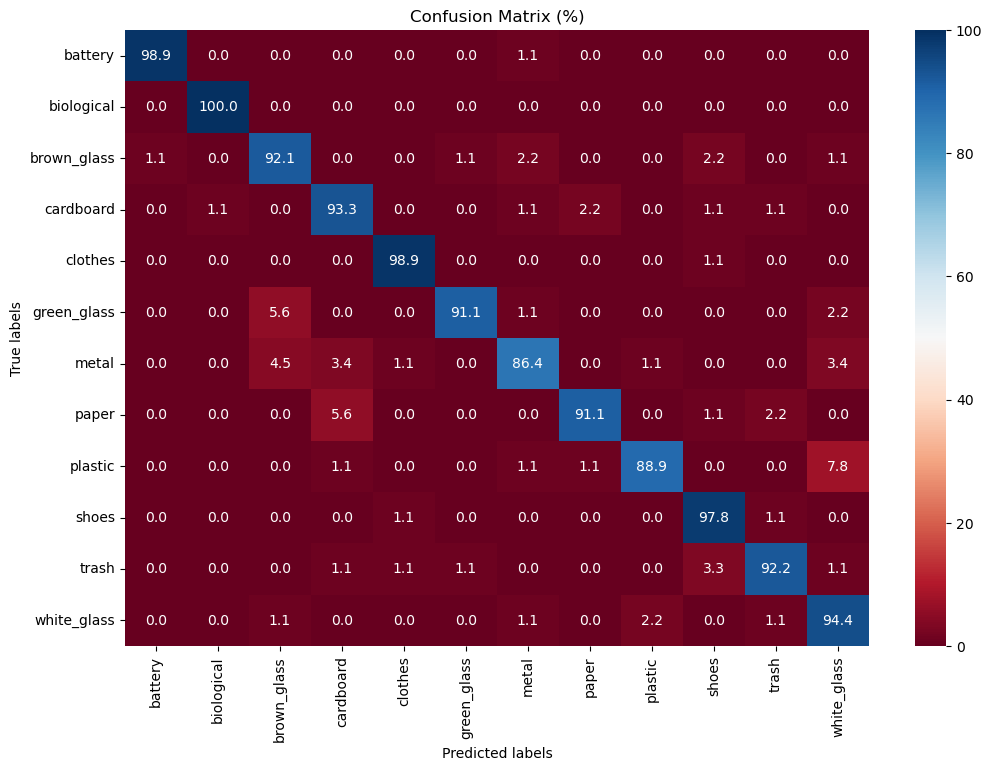

In [72]:
plt.figure(figsize=(12, 8))
sns.heatmap(CM_percent_df, annot=True, fmt='.1f', cmap='RdBu', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (%)')
plt.show()

# TensorFlow Lite

## Quantizar modelo

In [73]:
def representative_dataset_generator():
    for _ in range(100):
        data = next(val_images)[0]
        yield [data.astype(np.float32)]

In [74]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [75]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset =  representative_dataset_generator
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8 

In [76]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\CPQD\AppData\Local\Temp\tmp0dcoa1hr\assets


INFO:tensorflow:Assets written to: C:\Users\CPQD\AppData\Local\Temp\tmp0dcoa1hr\assets


In [77]:
with open(r"C:\Users\CPQD\Documents\vscode\tflite\resnet50.tflite", "wb") as f:
    f.write(tflite_model)

In [78]:
TF_MODEL_FILE_PATH=r"C:\Users\CPQD\Documents\vscode\tflite\resnet50.tflite"
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [141]:
nomes = interpreter.get_signature_list()
(a, b), = nomes.items()
entrada=b.get('inputs')[0]

In [142]:
nomes

{'serving_default': {'inputs': ['input_1'], 'outputs': ['dense_2']}}

In [80]:
classify_lite = interpreter.get_signature_runner('serving_default')

## Testar modelo quantizado

In [112]:
for i in range(len(test_images)):
    if i==0:
        minimo=test_images[i][0].min()
        maximo=test_images[i][0].max()
    if test_images[i][0].min() < minimo:
        minimo=test_images[i][0].min()
    if test_images[i][0].max() > maximo:
        maximo=test_images[i][0].max()

In [144]:
if maximo!=0 and minimo!=0: # nenhum valor extremo é zero 
    if minimo<0 and maximo<0: # todos os valores sao negativos
        fator=minimo*(-1)
        if maximo*(-1)>fator: # eh impossivel entrar neste caso, mas vou deixar aqui
            fator=maximo*(-1)
    if minimo<0 and maximo>0: # existem valores nas faixas negativa e positiva
        fator=minimo*(-1)
        if maximo>fator:
            fator=maximo
    if minimo>0 and maximo>0: # todos os valores sao positivos
         fator=maximo
         if minimo>fator: # eh impossivel entrar neste caso, mas vou deixar aqui
             fator=minimo
    fator=127/fator
    d=0 # deslocamento
else: # algum dos extremos é zero
    if minimo==0:
        fator=maximo
        fator=255/fator
        d=-128
    if maximo==0:
        fator=minimo*(-1)
        fator=255/fator
        d=127

In [145]:
fator

0.8407199482339983

In [146]:
d

0

o argumento de input é a string a seguir:

In [147]:
entrada

'input_1'

In [148]:
pred=[]
rotulo=[]
tempo=0
for i in range(len(test_images)):
    img=(test_images[i][0]*fator+d).astype("int8")
    start=time.time()
    predictions_lite = classify_lite(input_1=img)   # argumento entrada
    end=time.time()
    tempo=tempo+end-start
    (k, v), = predictions_lite.items()
    for j in range(batch_size):
        if i<len(test_images)-1:
            pred.append(np.argmax(v[j]))
            r=np.where(test_images[i][1] == 1)[1][j]
            rotulo.append(r)
        else:
            if j<len(test_images[len(test_images)-1][0]):
                pred.append(np.argmax(v[j]))
                r=np.where(test_images[i][1] == 1)[1][j]
                rotulo.append(r)
            else:
                break

In [149]:
a=0 # quantidade de acertos
e=[] # indices das imagens classificadas incorretamente
for i in range(len(pred)):
    if(pred[i]==rotulo[i]):
        a=a+1
    else:
        e.append(i)

In [150]:
print("Acertos: {:.2f}%".format(a/qtd * 100))

Acertos: 93.50%


In [151]:
print("Tempo de inferência médio: "+str(tempo/qtd)+" segundos")

Tempo de inferência médio: 0.45583220267583624 segundos


In [152]:
print(classification_report(rotulo, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        89
           1       0.98      0.98      0.98        91
           2       0.91      0.89      0.90        89
           3       0.88      0.96      0.91        90
           4       0.98      0.98      0.98        90
           5       0.96      0.91      0.94        90
           6       0.90      0.90      0.90        88
           7       0.95      0.92      0.94        90
           8       0.97      0.86      0.91        90
           9       0.92      0.97      0.94        91
          10       0.95      0.92      0.94        90
          11       0.85      0.96      0.90        89

    accuracy                           0.94      1077
   macro avg       0.94      0.93      0.93      1077
weighted avg       0.94      0.94      0.94      1077



In [153]:
CM_lite = confusion_matrix(rotulo, pred)

class_names = os.listdir(test_folder)

CM_lite_df = pd.DataFrame(CM_lite, index=class_names, columns=class_names)
total_true_lite = np.sum(CM_lite, axis=1)
CM_percent_lite = (CM_lite / total_true_lite[:, None]) * 100
CM_lite_percent_df = pd.DataFrame(CM_percent_lite, index=class_names, columns=class_names)

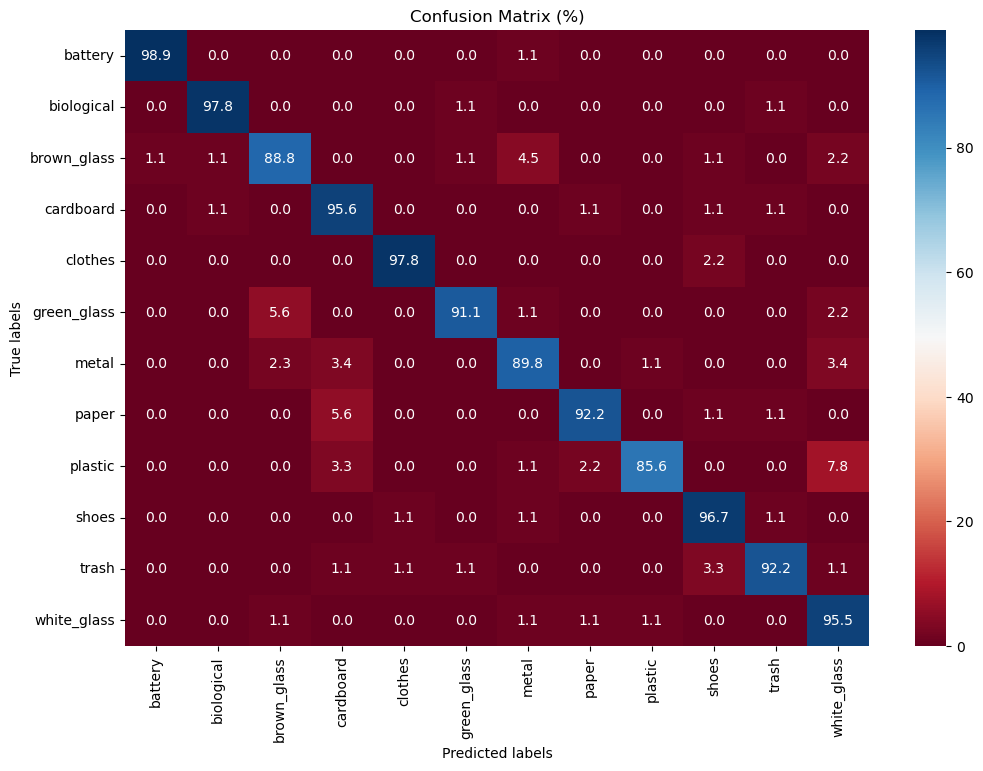

In [154]:
plt.figure(figsize=(12, 8))
sns.heatmap(CM_lite_percent_df, annot=True, fmt='.1f', cmap='RdBu', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (%)')
plt.show()